## Binary classification with Logistic regression 

### import libraries 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import pymysql
import getpass

### connection to sql 

In [2]:
mysqlpassword = getpass.getpass()
connection_string = 'mysql+pymysql://root:' + mysqlpassword + '@localhost/bank'
engine = create_engine(connection_string)

In [82]:
df=pd.read_sql_query('''
select l.status, count(distinct t.trans_id) as nooftrans,
datediff(19981231, convert(a.date, date)) as ageofaccount, 
d.A12 as 95unemp, d.A13 as 96unemp,
l.amount as loanamount, c.birth_number, d.A15 as crime95, d.A16 as crime96,
round((l.amount-l.payments)/l.amount,2) as ratiopaid,
t.k_symbol as trans_type
from loan l
left join trans t
using(account_id)
left join account a
using(account_id)
left join district d
on a.district_id = d.A1
left join disp dp
on a.account_id= dp.account_id 
left join client c
using(client_id)
where dp.type='OWNER'
group by loan_id, l.amount, status, d.A12, d.A13, c.birth_number, d.A15, d.A16, datediff(19981231, convert(a.date, date)),
 dp.type, round((l.amount-l.payments)/l.amount,2), t.k_symbol
''', engine)


### EDA - exploratory data analysis - get to know the data 

In [83]:
df.head(20)


,status,nooftrans,ageofaccount,95unemp,96unemp,loanamount,birth_number,crime95,crime96,ratiopaid,trans_type
0,A,191,2134,0.29,0.43,80952,450204,85677,99107,0.96,
1,A,32,2134,0.29,0.43,80952,450204,85677,99107,0.96,SIPO
2,A,65,2134,0.29,0.43,80952,450204,85677,99107,0.96,SLUZBY
3,A,70,2134,0.29,0.43,80952,450204,85677,99107,0.96,UROK
4,A,16,2134,0.29,0.43,80952,450204,85677,99107,0.96,UVER
5,B,89,1364,1.51,2.07,30276,395423,2299,2354,0.92,
6,B,8,1364,1.51,2.07,30276,395423,2299,2354,0.92,SANKC. UROK
7,B,26,1364,1.51,2.07,30276,395423,2299,2354,0.92,SIPO
8,B,40,1364,1.51,2.07,30276,395423,2299,2354,0.92,SLUZBY
9,B,90,1364,1.51,2.07,30276,395423,2299,2354,0.92,UROK


In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3382 entries, 0 to 3381
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   status        3382 non-null   object 
 1   nooftrans     3382 non-null   int64  
 2   ageofaccount  3382 non-null   int64  
 3   95unemp       3382 non-null   float64
 4   96unemp       3382 non-null   float64
 5   loanamount    3382 non-null   int64  
 6   birth_number  3382 non-null   int64  
 7   crime95       3382 non-null   int64  
 8   crime96       3382 non-null   int64  
 9   ratiopaid     3382 non-null   float64
 10  trans_type    3382 non-null   object 
dtypes: float64(3), int64(6), object(2)
memory usage: 290.8+ KB


In [85]:
df.describe()

,nooftrans,ageofaccount,95unemp,96unemp,loanamount,birth_number,crime95,crime96,ratiopaid
count,3382.000000,3382.000000,3382.000000,3382.000000,3382.000000,3382.000000,3382.000000,3382.000000,3382.000000
mean,46.150503,1224.512123,2.872915,3.536996,151247.219397,583167.102011,14726.410704,16439.907451,0.962454
std,49.217703,518.318978,1.889644,2.142543,114452.365902,127444.909748,27012.241517,31361.201323,0.022097
min,1.000000,374.000000,0.000000,0.430000,4980.000000,350129.000000,0.000000,888.000000,0.920000
25%,15.000000,808.250000,1.510000,1.960000,66432.000000,471210.000000,2159.000000,2305.000000,0.960000
50%,29.000000,1074.000000,2.770000,3.490000,116040.000000,581007.000000,3729.000000,3868.000000,0.970000
75%,59.000000,1684.000000,3.850000,4.790000,212400.000000,690119.000000,6949.000000,6872.000000,0.980000
max,330.000000,2178.000000,7.340000,9.400000,590820.000000,806207.000000,85677.000000,99107.000000,0.980000


In [86]:
df.birth_number.unique()

array([450204, 395423, 620209, 520826, 405130, 445613, 420128, 670921,
       506227, 530126, 455703, 391130, 670924, 446025, 711019, 400827,
       565105, 735108, 395517, 745630, 735526, 476019, 650731, 471008,
       370601, 610724, 655803, 575927, 415519, 605719, 665309, 565322,
       421210, 405212, 455924, 565913, 520803, 701218, 510806, 570217,
       556119, 610930, 600628, 480521, 775510, 545316, 715826, 350129,
       406126, 585915, 586230, 666002, 755901, 440506, 455612, 361127,
       505313, 791027, 566218, 636231, 686220, 516129, 460122, 715625,
       425419, 625306, 466017, 601222, 441215, 390929, 411111, 670907,
       570429, 401125, 465701, 655818, 455317, 510724, 755912, 620905,
       680415, 695313, 575122, 371213, 400607, 505926, 430312, 405724,
       510906, 535720, 495516, 475722, 680722, 741022, 425913, 521212,
       405420, 505102, 665410, 790325, 575823, 570919, 700325, 481218,
       550521, 635125, 765609, 371028, 391206, 430614, 755128, 710106,
      

In [87]:
df['status'].value_counts()

C    1954
A    1001
D     252
B     175
Name: status, dtype: int64

In [88]:
df['trans_type'].value_counts()

SLUZBY         682
UROK           682
UVER           674
               643
SIPO           468
POJISTNE       114
SANKC. UROK     80
                39
Name: trans_type, dtype: int64

### histograms or boxplots



<AxesSubplot:xlabel='nooftrans', ylabel='Count'>

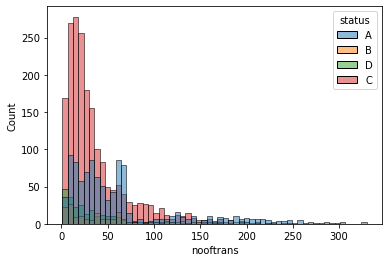

In [89]:
sns.histplot(df, x='nooftrans', hue='status')

<AxesSubplot:xlabel='trans_type', ylabel='Count'>

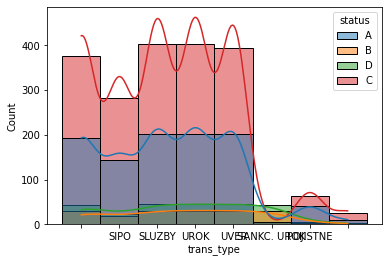

In [90]:
sns.histplot(df, x='trans_type', hue='status', kde=True)

<AxesSubplot:xlabel='loanamount', ylabel='status'>

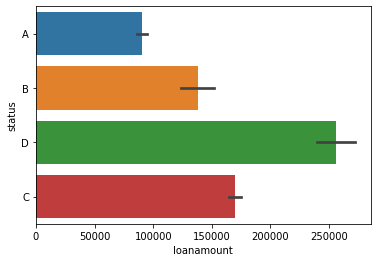

In [91]:
sns.barplot(x='loanamount', y='status', data=df)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='ageofaccount', ylabel='Density'>

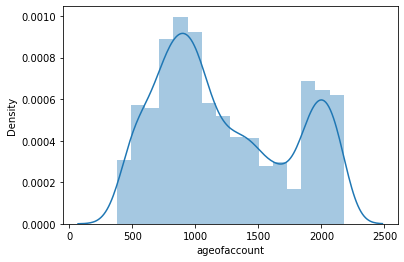

In [92]:
sns.distplot(df['ageofaccount'])

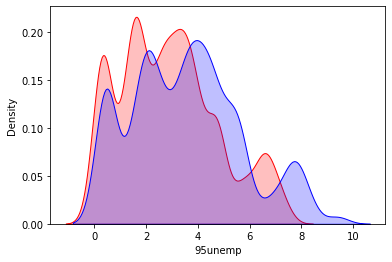

In [93]:
fig = sns.kdeplot(df['95unemp'], shade=True, color="r")
fig = sns.kdeplot(df['96unemp'], shade=True, color="b")
plt.show()

### Check for multicollinearity 

In [94]:

correlation = df.corr()
correlation


,nooftrans,ageofaccount,95unemp,96unemp,loanamount,birth_number,crime95,crime96,ratiopaid
nooftrans,1.000000,0.428359,-0.014224,-0.019200,-0.036264,0.022545,0.028787,0.028605,-0.043902
ageofaccount,0.428359,1.000000,-0.030222,-0.046723,-0.066998,0.048436,0.063701,0.063685,-0.073574
95unemp,-0.014224,-0.030222,1.000000,0.936864,-0.066922,-0.058346,-0.486045,-0.491611,-0.037966
96unemp,-0.019200,-0.046723,0.936864,1.000000,-0.040762,-0.046176,-0.525115,-0.528310,-0.032728
loanamount,-0.036264,-0.066998,-0.066922,-0.040762,1.000000,0.070794,0.020973,0.020626,0.538177
birth_number,0.022545,0.048436,-0.058346,-0.046176,0.070794,1.000000,0.059416,0.059838,0.047787
crime95,0.028787,0.063701,-0.486045,-0.525115,0.020973,0.059416,1.000000,0.999648,-0.047624
crime96,0.028605,0.063685,-0.491611,-0.528310,0.020626,0.059838,0.999648,1.000000,-0.047178
ratiopaid,-0.043902,-0.073574,-0.037966,-0.032728,0.538177,0.047787,-0.047624,-0.047178,1.000000


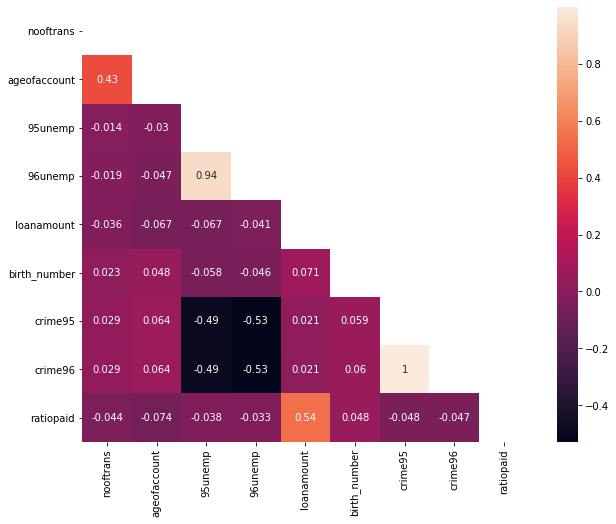

In [95]:

corr_matrix = df.corr(method='pearson')
fig,ax = plt.subplots(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
ax = sns.heatmap(corr_matrix, mask=mask, annot=True )


### Clean and wrangling steps 

In [96]:
# clean /wrangling steps suggested :
# bucket into categories any fields 
# should we drop any columns ? (iterative process)
# extract gender from birth_number
# data type changes 
#drop highly correlated features 
#create avg of criminality / unempl rate 
# crime - divide by population 
# bring in any missing fields 
# change unempl into HML 
# change crime numbers into one column - sum the two columns 
#bring in the C and D statuses - and then using a function map to good or bad 
# OR multi class regression ?
# k symbol might be worth including 
# loan duration 
# feature engineering - take the columns and make more useful 

# split the data into num and cat --- > diff options cleaning / scaling

In [97]:
df['crime_sum'] = df['crime95'] + df['crime96']

In [98]:
df.drop(['crime95', 'crime96'], axis=1, inplace=True)

In [99]:
#df.drop(['crime_sum'], axis=1, inplace=True)

In [100]:
df.head()

,status,nooftrans,ageofaccount,95unemp,96unemp,loanamount,birth_number,ratiopaid,trans_type,crime_sum
0,A,191,2134,0.29,0.43,80952,450204,0.96,,184784
1,A,32,2134,0.29,0.43,80952,450204,0.96,SIPO,184784
2,A,65,2134,0.29,0.43,80952,450204,0.96,SLUZBY,184784
3,A,70,2134,0.29,0.43,80952,450204,0.96,UROK,184784
4,A,16,2134,0.29,0.43,80952,450204,0.96,UVER,184784


### Pre processing 

In [101]:
# label / encode categorical columns 
# scale numerical columns 

In [102]:
from sklearn.preprocessing import OrdinalEncoder
# encoding trans type and frequency to numeric
ord_enc = OrdinalEncoder()
df["trans_type"] = ord_enc.fit_transform(df[["trans_type"]])
df.head(30)

,status,nooftrans,ageofaccount,95unemp,96unemp,loanamount,birth_number,ratiopaid,trans_type,crime_sum
0,A,191,2134,0.29,0.43,80952,450204,0.96,0.0,184784
1,A,32,2134,0.29,0.43,80952,450204,0.96,4.0,184784
2,A,65,2134,0.29,0.43,80952,450204,0.96,5.0,184784
3,A,70,2134,0.29,0.43,80952,450204,0.96,6.0,184784
4,A,16,2134,0.29,0.43,80952,450204,0.96,7.0,184784
5,B,89,1364,1.51,2.07,30276,395423,0.92,0.0,4653
6,B,8,1364,1.51,2.07,30276,395423,0.92,3.0,4653
7,B,26,1364,1.51,2.07,30276,395423,0.92,4.0,4653
8,B,40,1364,1.51,2.07,30276,395423,0.92,5.0,4653
9,B,90,1364,1.51,2.07,30276,395423,0.92,6.0,4653


In [103]:
df['trans_type'].value_counts()

6.0    682
5.0    682
7.0    674
0.0    643
4.0    468
2.0    114
3.0     80
1.0     39
Name: trans_type, dtype: int64

In [104]:
def status_group(x):
    if x in ['B', 'D']:
        return 0
    else:
        return 1

In [105]:
df['status'] = list(map(status_group, df['status']))

In [106]:
#cat = pd.get_dummies(cat, columns=['status'], drop_first=True)
#cat.head()

In [107]:
# numerical scaling
from sklearn.preprocessing import Normalizer

In [108]:
X = df.select_dtypes(include=np.number)
X.head(20)

,status,nooftrans,ageofaccount,95unemp,96unemp,loanamount,birth_number,ratiopaid,trans_type,crime_sum
0,1,191,2134,0.29,0.43,80952,450204,0.96,0.0,184784
1,1,32,2134,0.29,0.43,80952,450204,0.96,4.0,184784
2,1,65,2134,0.29,0.43,80952,450204,0.96,5.0,184784
3,1,70,2134,0.29,0.43,80952,450204,0.96,6.0,184784
4,1,16,2134,0.29,0.43,80952,450204,0.96,7.0,184784
5,0,89,1364,1.51,2.07,30276,395423,0.92,0.0,4653
6,0,8,1364,1.51,2.07,30276,395423,0.92,3.0,4653
7,0,26,1364,1.51,2.07,30276,395423,0.92,4.0,4653
8,0,40,1364,1.51,2.07,30276,395423,0.92,5.0,4653
9,0,90,1364,1.51,2.07,30276,395423,0.92,6.0,4653


In [109]:
cat = df['status']
df.drop(['status'], axis=1, inplace=True)
cat.head()

0    1
1    1
2    1
3    1
4    1
Name: status, dtype: int64

In [110]:
scaler = Normalizer().fit(X)
scaled = scaler.transform(X) # scaling to gaussian distr
scaled_X = pd.DataFrame(scaled) # convert back to DF
scaled_X.head()


,0,1,2,3,4,5,6,7,8,9
0,0.000002,0.000387,0.004326,5.878272e-07,8.716059e-07,0.164089,0.912559,0.000002,0.000000,0.374555
1,0.000002,0.000065,0.004326,5.878272e-07,8.716059e-07,0.164089,0.912559,0.000002,0.000008,0.374555
2,0.000002,0.000132,0.004326,5.878272e-07,8.716059e-07,0.164089,0.912559,0.000002,0.000010,0.374555
3,0.000002,0.000142,0.004326,5.878272e-07,8.716059e-07,0.164089,0.912559,0.000002,0.000012,0.374555
4,0.000002,0.000032,0.004326,5.878272e-07,8.716059e-07,0.164089,0.912559,0.000002,0.000014,0.374555


In [111]:
# if there are more categorical values, we have to concat back to the DF
# scaled_X = pd.concat([scaled_X, categorical['trans_type']], axis=1)

### split off the dependant variable (label)

In [112]:
# y is a dependent variable (status)
y = cat
X = scaled_X
X.head(20)

,0,1,2,3,4,5,6,7,8,9
0,0.000002,0.000387,0.004326,5.878272e-07,8.716059e-07,0.164089,0.912559,0.000002,0.000000,0.374555
1,0.000002,0.000065,0.004326,5.878272e-07,8.716059e-07,0.164089,0.912559,0.000002,0.000008,0.374555
2,0.000002,0.000132,0.004326,5.878272e-07,8.716059e-07,0.164089,0.912559,0.000002,0.000010,0.374555
3,0.000002,0.000142,0.004326,5.878272e-07,8.716059e-07,0.164089,0.912559,0.000002,0.000012,0.374555
4,0.000002,0.000032,0.004326,5.878272e-07,8.716059e-07,0.164089,0.912559,0.000002,0.000014,0.374555
5,0.000000,0.000224,0.003439,3.807266e-06,5.219233e-06,0.076337,0.997007,0.000002,0.000000,0.011732
6,0.000000,0.000020,0.003439,3.807267e-06,5.219233e-06,0.076337,0.997007,0.000002,0.000008,0.011732
7,0.000000,0.000066,0.003439,3.807267e-06,5.219233e-06,0.076337,0.997007,0.000002,0.000010,0.011732
8,0.000000,0.000101,0.003439,3.807267e-06,5.219233e-06,0.076337,0.997007,0.000002,0.000013,0.011732
9,0.000000,0.000227,0.003439,3.807266e-06,5.219233e-06,0.076337,0.997007,0.000002,0.000015,0.011732


### train test split, get LOG REG model

In [113]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=40) #def train and test sets

## apply model and train model 

In [115]:
classification = LogisticRegression(solver='liblinear', multi_class='ovr').fit(X_train, y_train) # training

### evaluate accuracy and test 

In [116]:
probabilities = classification.predict_proba(X_test)
preds = probabilities[:,1] # part of the array of predictions
import sklearn.metrics as metrics
fpr, tpr, treshold = metrics.roc_curve(y_test, preds) #fpr=FalsePositiveRate, tpr=TruePositiveRate, auc=AreaUnderTheCurve 
roc_auc = metrics.auc(fpr, tpr)
roc_auc

0.6546557086172774

#### next steps

+ Visualise the accuracy of the predictions in some ways 

+ also think about - is there something I could do to improve my model accuracy?? 

### visualising accuracy - ROC / AUC 

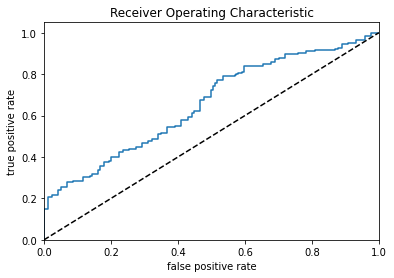

In [117]:
#roc curve plot 
plt.title('Receiver Operating Characteristic')
plt.plot(fpr,tpr, label='AUC'%roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel('true positive rate')
plt.xlabel('false positive rate')
plt.show()


### visualising accuracy - Confusion Matrix

##### definitions 
+ tpr = true positive rate 
+ fpr = false positive rate

In [118]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

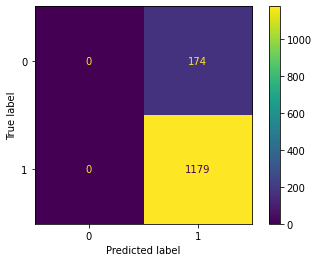

In [119]:
predictions = classification.predict(X_test)
accuracy_score(y_test, predictions)
confusion_matrix(y_test, predictions)
plot_confusion_matrix(classification, X_test, y_test)

### data is highly imbalanced

this is affecting the accuracy of our predictions 
- what can be done to resolve that ?


+ option 1 - SMOTE 

+ option 2 - TOMEK LINKS 

